## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

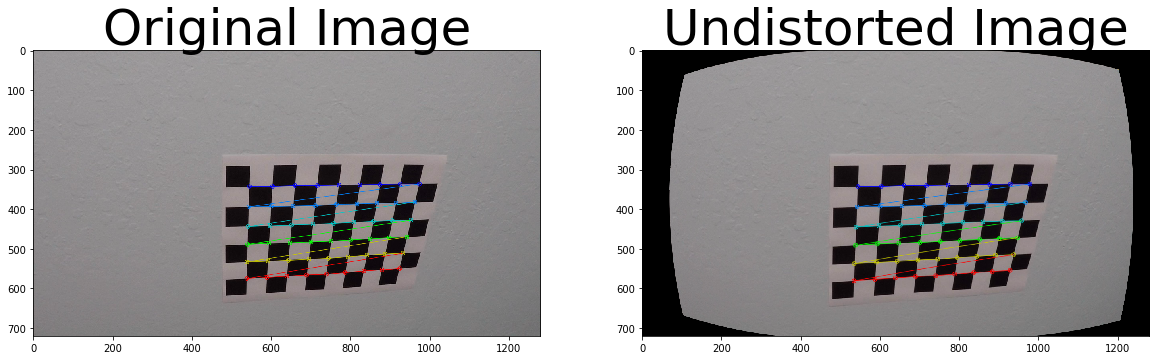

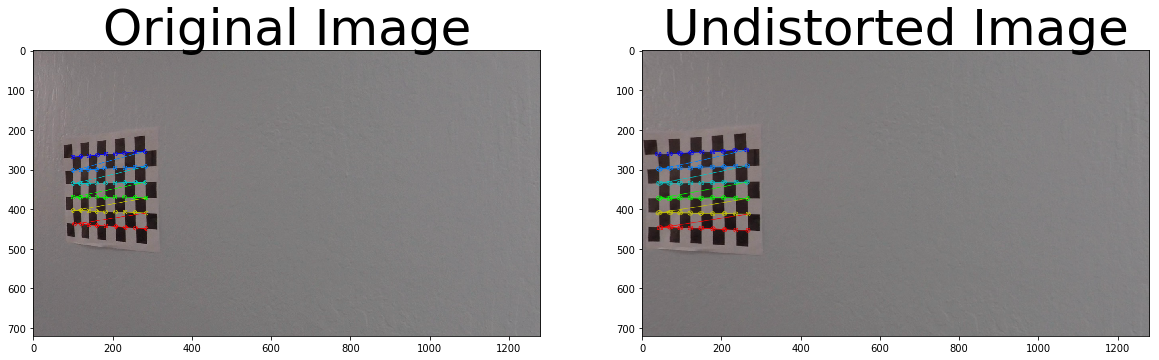

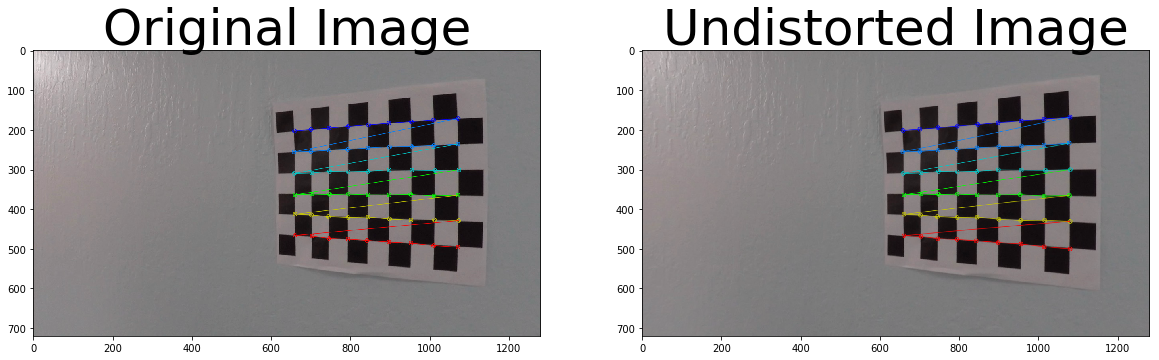

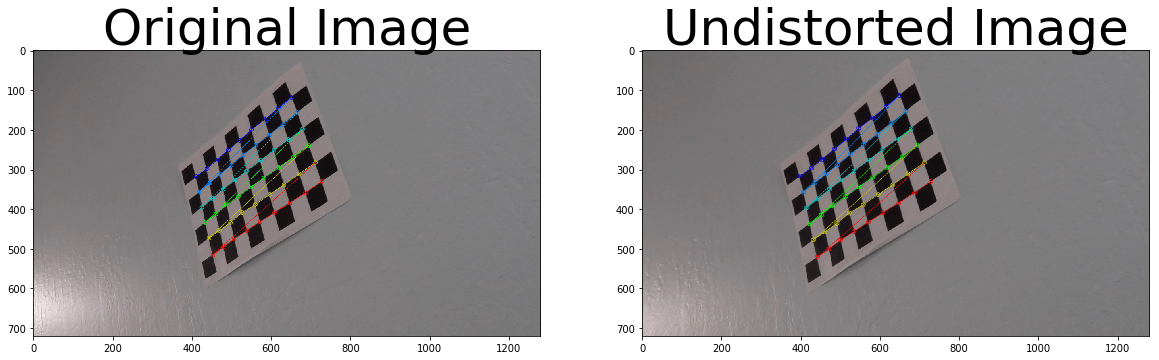

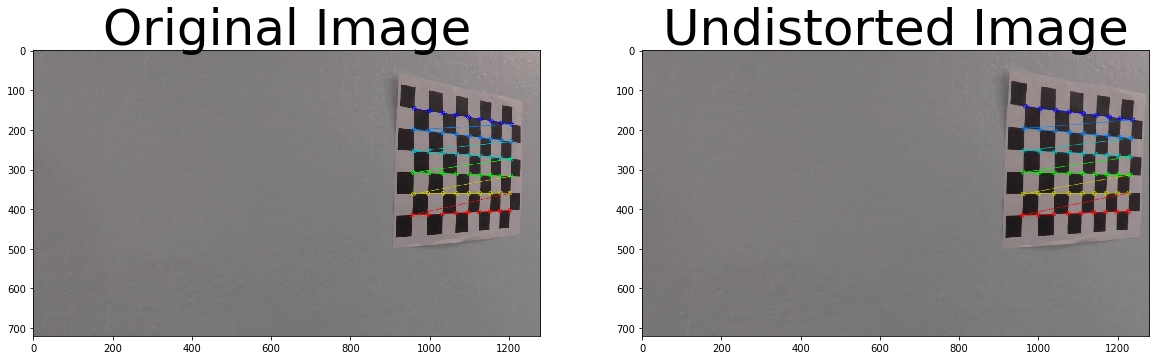

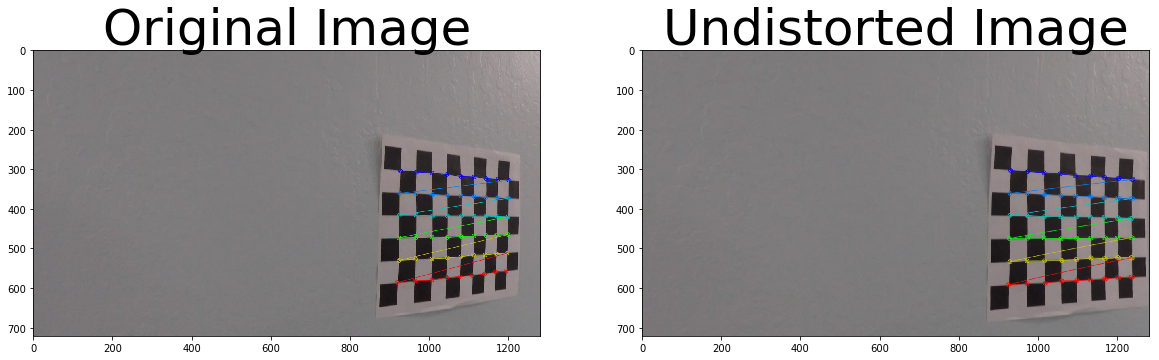

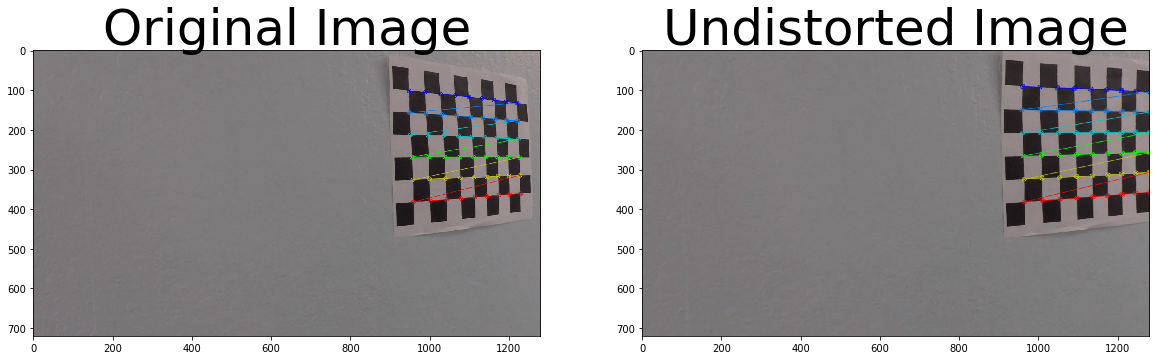

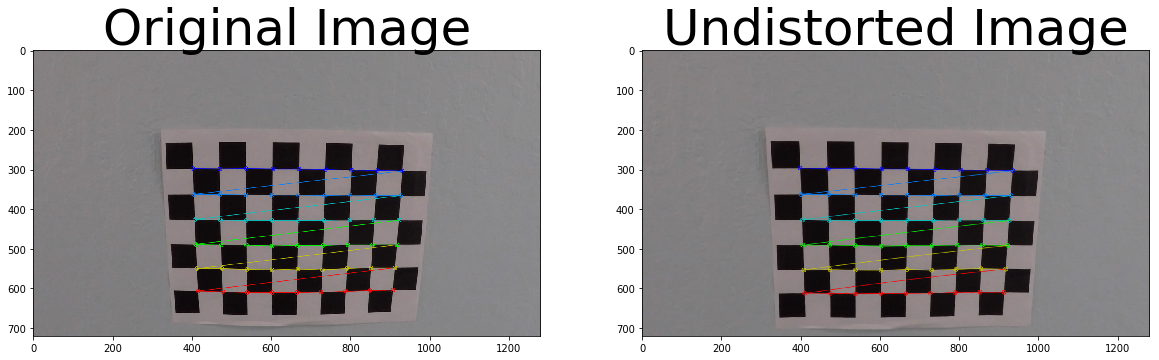

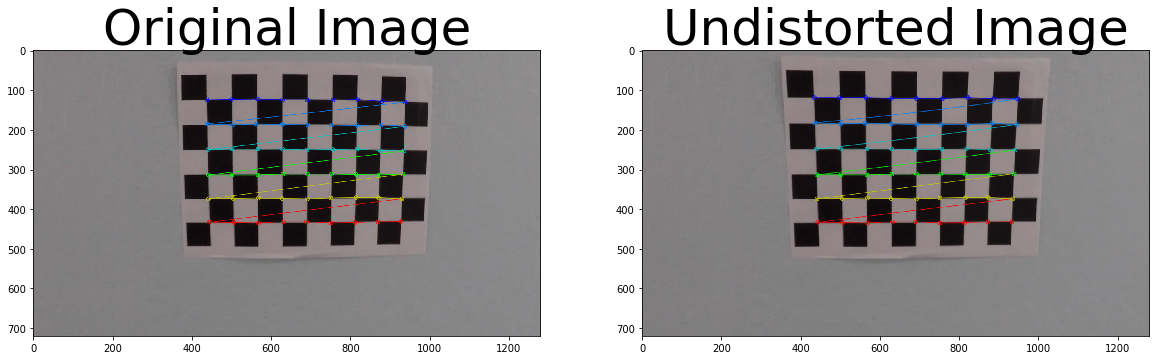

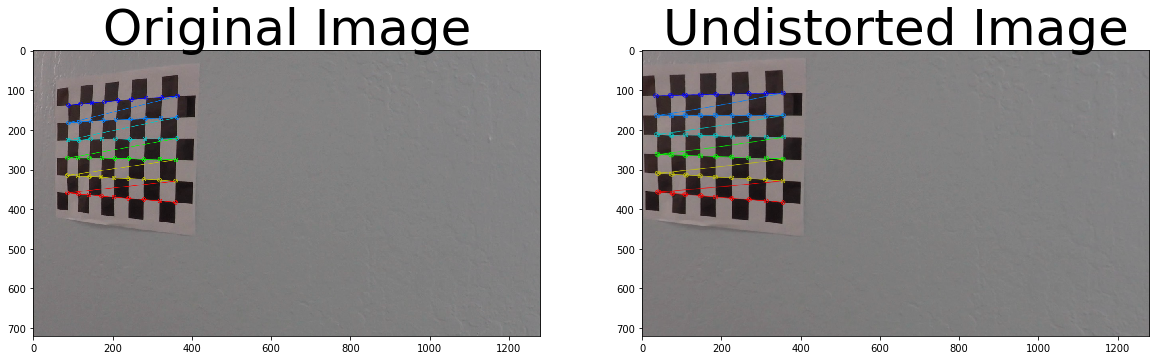

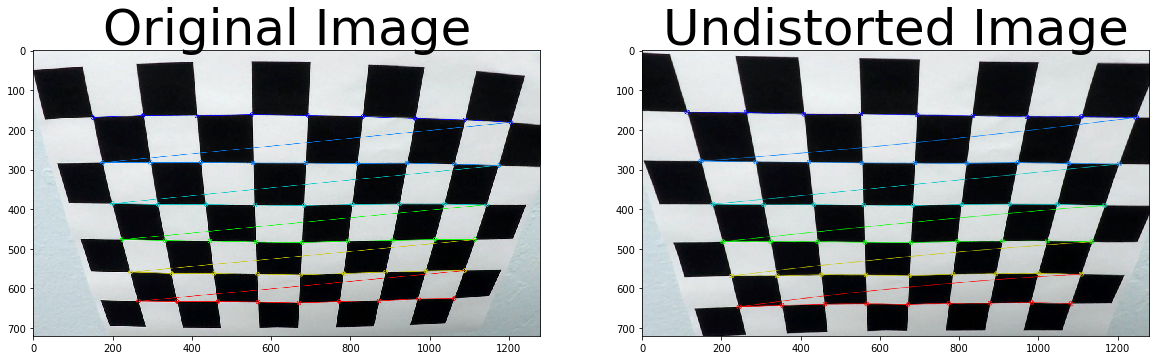

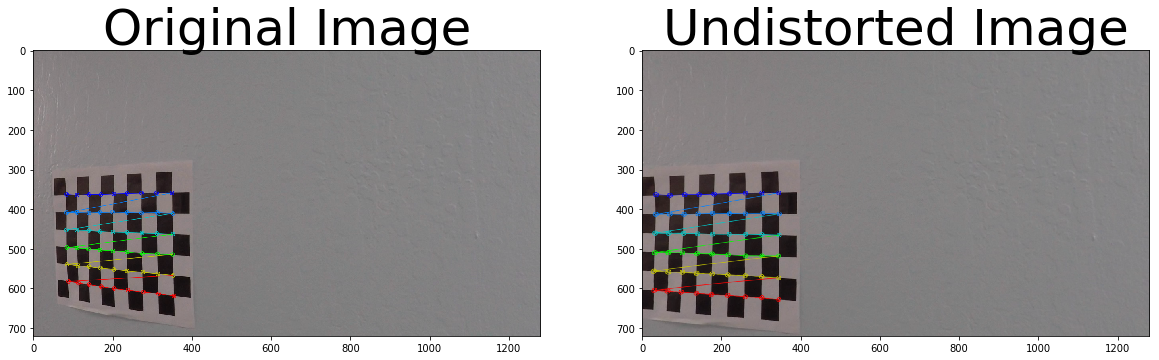

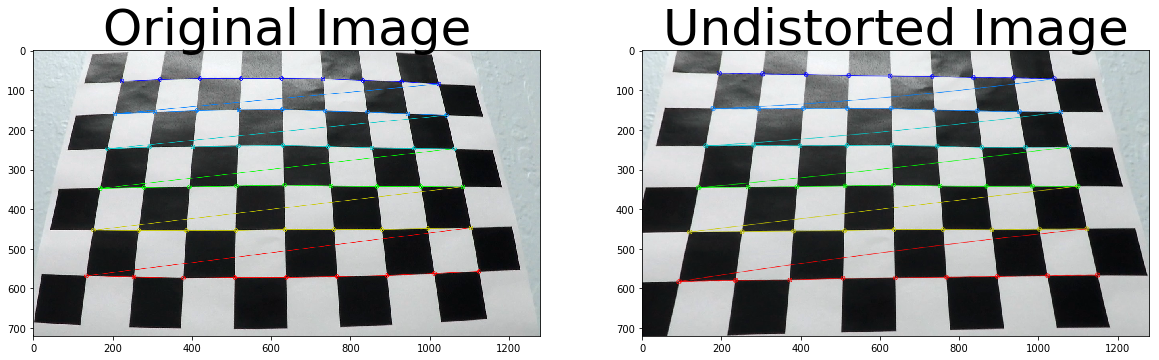

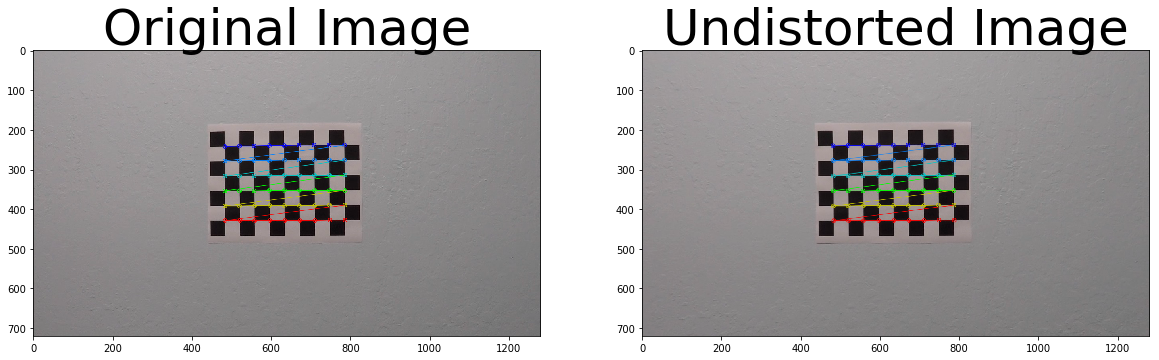

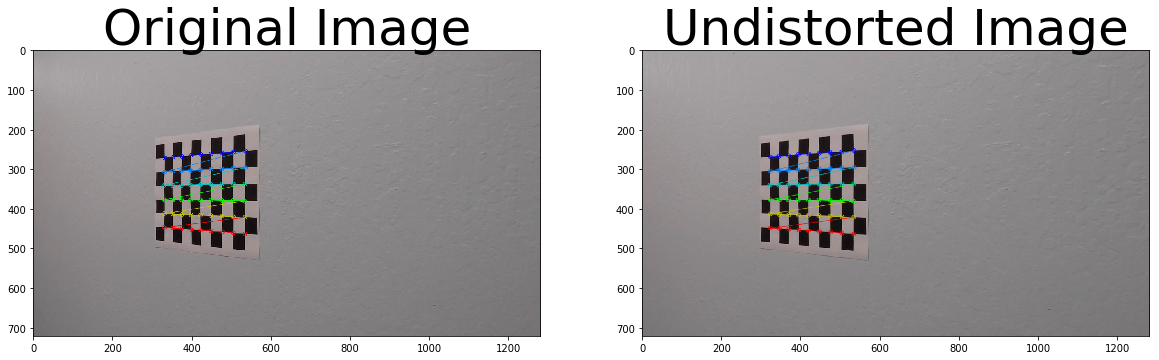

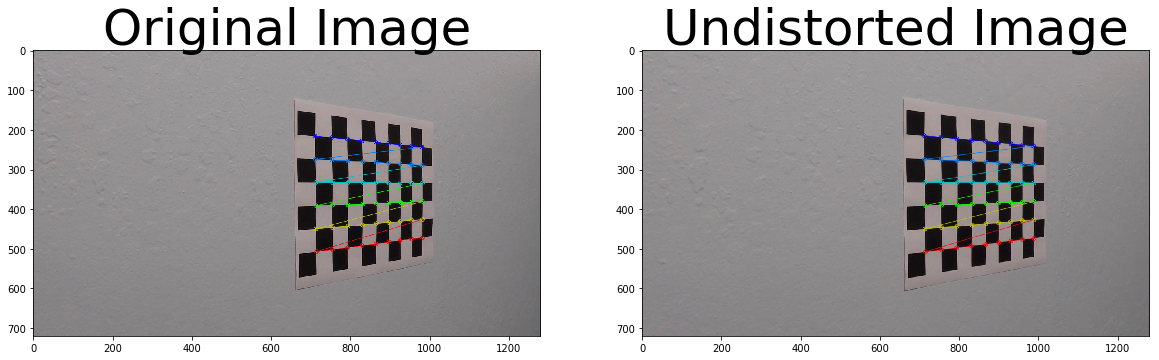

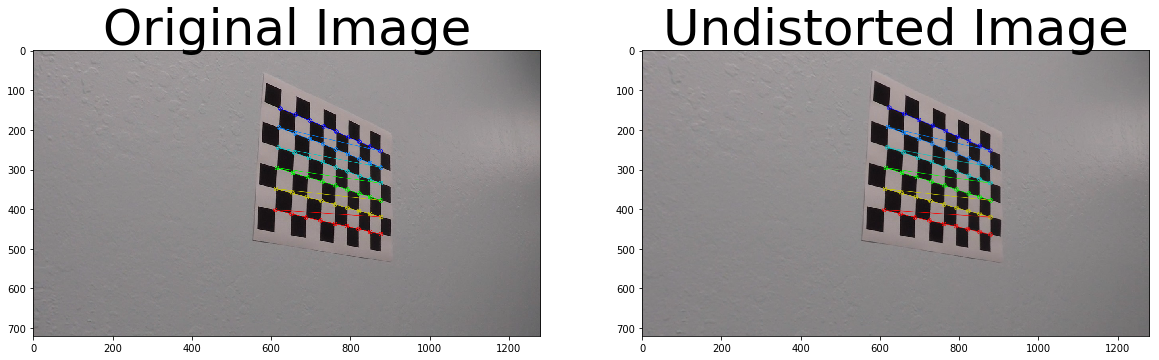

In [10]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
# or you can use 'qt'

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

nx = 9
ny = 6

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# My code

        # Calculate calibration of camera  
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#         f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
#         plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#         cv2.destroyAllWindows()

        
        

## Warp

In [ ]:

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
            # a) draw corners
    img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)        
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
    
    corners_array = np.array(corners, dtype=np.float32)
    src = np.float32([corners_array[0][0],corners_array[7][0],corners_array[40][0],corners_array[47][0]])
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[100,100],[1200,100],[100,900],[1200,900]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    img_size = img.shape
    # print (corners_array)
    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    #delete the next two lines
    # plt.imshow(img)
    # for i in range(len(src)):
    #     plt.plot (src[i][0], src[i][1], ".")
    # M = None
    # warped = np.copy(img) 
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Sobel

In [ ]:
def abs_sobel_thresh(image, orient, sobel_kernel, thresh):
    # Calculate directional gradient
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if orient == 'x':
        abs_sobel = np.absolute(sobelx)
    else:
        abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel, mag_thresh):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    mag_binary = np.zeros_like(mag_sobel)
    mag_binary[(mag_sobel > mag_thresh[0]) & (mag_sobel < mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel, thresh):
    # Calculate gradient direction
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan_sobel = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan_sobel)
    dir_binary[(arctan_sobel > thresh[0]) & (arctan_sobel < thresh[1])] = 1
    return dir_binary

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# # Apply each of the thresholding functions
# gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
# grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
# mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30,100))
# dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

## HLS